In [271]:
import pandas as pd
from tqdm import tqdm
import openml
import sklearn
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import random
import numpy as np
import seaborn as sns

### Preprocessing Data

In [3]:
'''
Downloading additional data from OpenML
'''

datasets = openml.datasets.list_datasets(output_format = 'dataframe')
tasks = openml.tasks.list_tasks(output_format="dataframe")
flows = openml.flows.list_flows(output_format = 'dataframe')
suites = openml.study.list_suites(output_format="dataframe", status="all")

datasets = datasets.rename(columns={'did': 'data_id', 'name': 'data_name'})
tasks = tasks.rename(columns={'did': 'data_id', 'tid': 'task_id', 'name': 'data_name'})
flows = flows.rename(columns={'full_name': 'flow_name', 'name': 'flow_name_type', 'id': 'flow_id'})

df_openml = pd.read_csv('df_openml_all2.csv')

In [ ]:
'''
Downloading data from OpenML
'''
# df_openml = pd.DataFrame()
# tasks.task_id.unique()

# for i in tqdm(tasks.task_id.unique()):
#     try:
#         df_openml = df_openml.append(openml.evaluations.list_evaluations(
#             function = 'area_under_roc_curve',
#             tasks = [i],
#             output_format='dataframe',
#             size = None))
#     except:
#         None

# df_openml.to_csv('df_openml_all2.csv')

In [193]:
# Отавляем модели только с sklearn
df_openml_sklearn = df_openml[df_openml['flow_name'].str.startswith('sklearn')]
# Удаление одинаковых моделей для каждого task_id, оставляя с лучшим score
data_with_best_model = df_openml_sklearn.groupby(['task_id','flow_name']).apply(lambda x: x.nlargest(1,['value'])).reset_index(drop=True)

TOP = 5    # количество лучших и худших моделей для каждого task_id
# POSITIVE_SAMPLES
df_top_positive = data_with_best_model.groupby(['task_id']).apply(lambda x: x.nlargest(TOP,['value']))
df_top_positive['label'] = [1]*len(df_top_positive)
# NEGATIVE_SAMPLES
df_top_negative = data_with_best_model.groupby(['task_id']).apply(lambda x: x.nsmallest(TOP,['value']))
df_top_negative['label'] = [0]*len(df_top_negative)

df_top = pd.concat([df_top_positive, df_top_negative])

# Объединение различных таблиц с OpenML (например, доп информация о датасете и тд)
df_top_merge = pd.merge(df_top, datasets[list(set(datasets.columns) - set(df_top.columns)) + ['data_name', 'data_id']], on = ['data_name', 'data_id'])
df_top_merge = pd.merge(df_top_merge, tasks[list(set(tasks.columns) - set(df_top_merge.columns)) + ['task_id', 'data_id']], on = ['task_id', 'data_id'])
df_top_merge = pd.merge(df_top_merge, flows[list(set(flows.columns) - set(df_top_merge.columns)) + ['flow_id', 'flow_name']], on = ['flow_id', 'flow_name'])
df_top_merge.to_csv('OpenML_neg+pos.csv')

# Оставляем только те task_id, для которых количество samples получилось не меньше 10
temp = df_top_merge['task_id'].value_counts()
df_top_merge = df_top_merge[df_top_merge['task_id'].isin(list(temp[temp==TOP*2].index))]

In [234]:
# Удаление неинформативных столбцов
columns = set(df_top_merge.columns) - set(['Unnamed: 0', 'run_id',	'setup_id',	'flow_id', 'flow_name', 'data_id', 'data_name', 'upload_time',
                                            'uploader', 'uploader_name', 'values',	'array_data', 'version', 'status', 'target_value',	'target_feature_right',
                                            'target_feature_event',	'quality_measure',	'source_data',	'source_data_labeled',	'number_samples', 'external_version'])
X_columns = list(columns - {'label'}) #{'value', 'task_id'}
Y_column = ['label']

In [ ]:
X = df_top_merge[X_columns]
y = df_top_merge[Y_column]

# Заполнение пропусков и преобразование категориальных данных
cols=X.select_dtypes(include='object').columns.to_list()
X[cols] = X[cols].fillna('nan')
X[cols] = X[cols].astype(str)
X[list(set(X.columns)-set(cols))] = X[list(set(X.columns)-set(cols))].fillna(-1)
enc = OrdinalEncoder()
enc.fit(X[cols])
X[cols] = enc.transform(X[cols])

# Разделение данных на train и test по task_id
task_id_uniq = df_top_merge['task_id'].unique()
SIZE_TRAIN = 0.8
train_task_id = random.sample(list(task_id_uniq), round(len(task_id_uniq)*SIZE_TRAIN))
test_task_id = list(set(task_id_uniq) - set(train_task_id))

X_train = X[X.index.isin(list(df_top_merge[df_top_merge['task_id'].isin(train_task_id)].index))]
y_train = y[y.index.isin(list(df_top_merge[df_top_merge['task_id'].isin(train_task_id)].index))]
X_test = X[X.index.isin(list(df_top_merge[df_top_merge['task_id'].isin(test_task_id)].index))]
y_test = y[y.index.isin(list(df_top_merge[df_top_merge['task_id'].isin(test_task_id)].index))]
# X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42, stratify=X[['task_id']])

### CatBoost

F1-score: 0.740399385560676
NDCG: 0.992224425494961


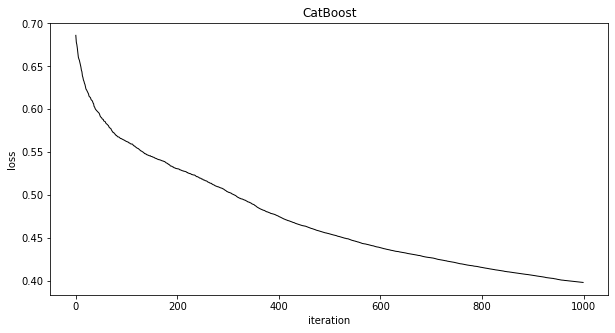

In [233]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(random_state=1, iterations=1000,
                           learning_rate=0.03,
                            l2_leaf_reg=3,
                            loss_function='CrossEntropy',
                           depth=6, verbose=False)
model.fit(X_train[list(set(X_train.columns) - {'value', 'task_id'})], y_train)
preds_class = model.predict(X_test[list(set(X_test.columns) - {'value', 'task_id'})])
preds_proba = model.predict_proba(X_test[list(set(X_test.columns) - {'value', 'task_id'})])

test_data = X_test.copy()
test_data['prob'] = preds_proba[:,1]
y_true = test_data.groupby('task_id')['value'].apply(list)
y_pred = test_data.groupby('task_id')['prob'].apply(list)
y_true = np.array([y_true.values[i] for i in range(len(y_true))])
y_pred = np.array([y_pred.values[i] for i in range(len(y_pred))])

fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('xkcd:white')
plt.plot(model.evals_result_['learn']['CrossEntropy'], color = 'black', linewidth=1)
plt.title('CatBoost')
plt.xlabel("iteration")
plt.ylabel("loss")

print(f'F1-score: {sklearn.metrics.f1_score(y_test, preds_class)}')
print(f'NDCG: {sklearn.metrics.ndcg_score(y_true, y_pred)}')


### MLPClassifier

/opt/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


F1-score: 0.4182509505703422
NDCG: 0.9648455150393722


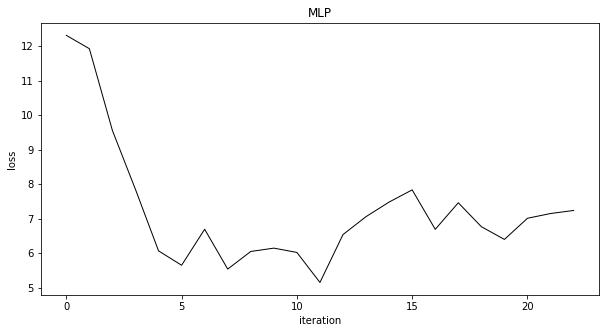

In [229]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, 
                    max_iter=1000,
                    verbose = False)

clf.fit(X_train[list(set(X_train.columns) - {'value', 'task_id'})], y_train)
preds_class = clf.predict(X_test[list(set(X_test.columns) - {'value', 'task_id'})])
preds_proba = clf.predict_proba(X_test[list(set(X_test.columns) - {'value', 'task_id'})])

test_data = X_test.copy()
test_data['prob'] = preds_proba[:,1]
y_true = test_data.groupby('task_id')['value'].apply(list)
y_pred = test_data.groupby('task_id')['prob'].apply(list)
y_true = np.array([y_true.values[i] for i in range(len(y_true))])
y_pred = np.array([y_pred.values[i] for i in range(len(y_pred))])

fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('xkcd:white')
plt.plot(clf.loss_curve_, color = 'black', linewidth=1)
plt.title('MLP')
plt.xlabel("iteration")
plt.ylabel("loss")

print(f'F1-score: {sklearn.metrics.f1_score(y_test, preds_class)}')
print(f'NDCG: {sklearn.metrics.ndcg_score(y_true, y_pred)}')


### Statistics

#### Raw data

In [287]:
libr_distr = df_openml['flow_name'].apply(lambda x: x.split('.')[0]).value_counts()

TOP = 10   
libr_distr_top = df_openml.groupby(['task_id']).apply(lambda x: x.nlargest(TOP,['value']))
libr_distr_top = libr_distr_top['flow_name'].apply(lambda x: x.split('.')[0]).value_counts()

<AxesSubplot:title={'center':'Distribution of used libraries on a logarithmic scale'}>

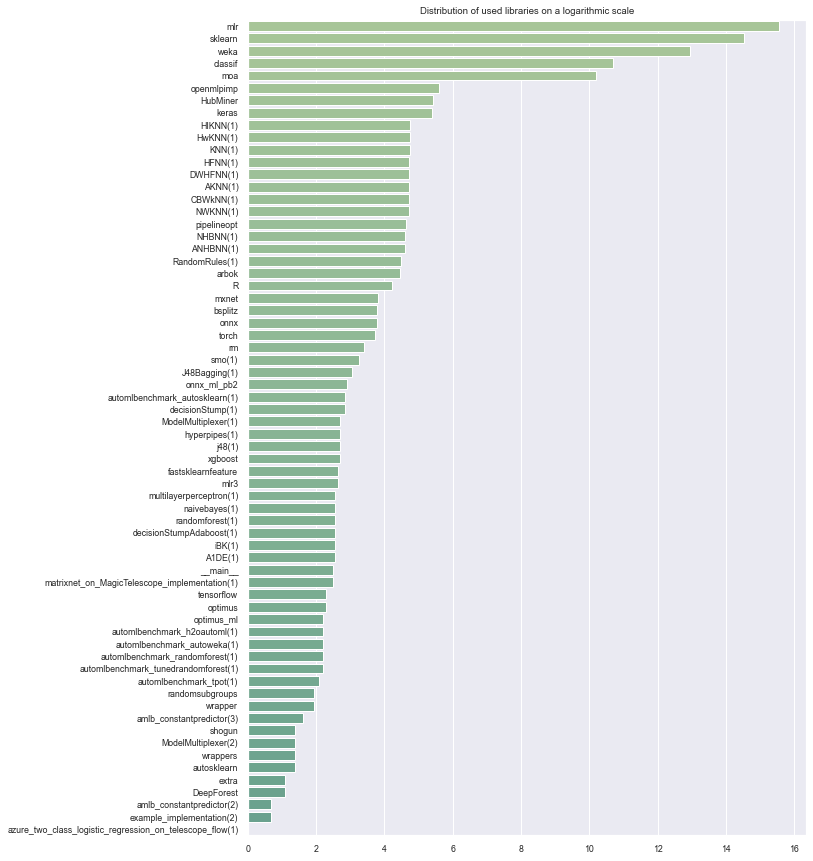

In [286]:
fig = plt.figure(figsize=(10,15))
fig.patch.set_facecolor('xkcd:white')
sns.set(font_scale=0.8)
palette = sns.color_palette("crest", as_cmap=True)
plt.title('Distribution of used libraries on a logarithmic scale')
sns.barplot(y=libr_distr.index[:-30], x=np.log(libr_distr.values)[:-30], palette=palette.colors)

<AxesSubplot:title={'center':'Distribution of libraries by score on a logarithmic scale'}>

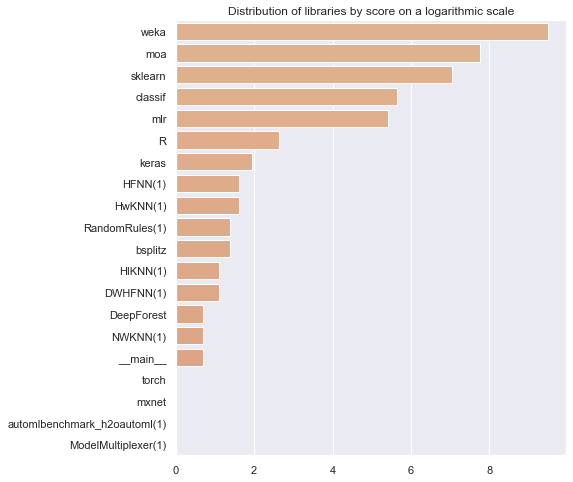

In [297]:
fig = plt.figure(figsize=(7,8))
fig.patch.set_facecolor('xkcd:white')
sns.set(font_scale=1)
palette = sns.color_palette("flare", as_cmap=True)
plt.title('Distribution of libraries by score on a logarithmic scale')
sns.barplot(y=libr_distr_top.index, x=np.log(libr_distr_top.values), palette=palette.colors)

In [298]:
df_openml.columns

Index(['Unnamed: 0', 'run_id', 'task_id', 'setup_id', 'flow_id', 'flow_name',
       'data_id', 'data_name', 'function', 'upload_time', 'uploader',
       'uploader_name', 'value', 'values', 'array_data'],
      dtype='object')

In [301]:
print(f'Data amount: {len(df_openml)}')
print(f'Datasets: {df_openml.data_id.nunique()}')
print(f'Tasks: {df_openml.task_id.nunique()}')
print(f'Model: {df_openml.flow_name.nunique()}')

Data amount: 8283681
Datasets: 895
Tasks: 1793
Model: 4755


#### Processed data

In [302]:
print(f'Data amount: {len(df_top_merge)}')
print(f'Datasets: {df_top_merge.data_id.nunique()}')
print(f'Tasks: {df_top_merge.task_id.nunique()}')
print(f'Model: {df_top_merge.flow_name.nunique()}')

Data amount: 3180
Datasets: 312
Tasks: 318
Model: 338


In [ ]:
# df_top_merge[df_top_merge['flow_name_type'].apply(lambda x: x.endswith('RandomForest'))]['flow_name_type'].unique()